### Import libraries

In [29]:
import re
import string
import nltk
import numpy as np
import pandas as pd
# nltk.download()
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV, StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

### Read data

In [3]:
# There are 3 different txt data so we will read them separately and concatenate them
amazon_df = pd.read_csv("C:/Users/HP/Downloads/sentiment labelled sentences/sentiment labelled sentences/amazon_cells_labelled.txt",delimiter='\t',header=None)
imdb_df = pd.read_csv("C:/Users/HP/Downloads/sentiment labelled sentences/sentiment labelled sentences/imdb_labelled.txt",delimiter='\t',header=None)
yelp_df = pd.read_csv("C:/Users/HP/Downloads/sentiment labelled sentences/sentiment labelled sentences/yelp_labelled.txt",delimiter='\t',header=None)

#concat dataset
df = pd.concat([amazon_df, imdb_df, yelp_df], axis=0, ignore_index=True)
df.columns=['text','label']

In [4]:
df.head()

,text,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [5]:
# we can see that the dataset is balanced
df.label.value_counts()

1    1386
0    1362
Name: label, dtype: int64

In [6]:
# We first have to clean the text data
nltk.download('stopwords')
nltk.download('wordnet')
def clean_text(df, text_column):
    
    stop_words = nltk.corpus.stopwords.words('english')
    lemmatizer = nltk.stem.WordNetLemmatizer()
    
    df[text_column] = df[text_column].str.lower() # convert to lowercase
    df[text_column] = df[text_column].apply(lambda x: re.sub(r'http\S+', '', x)) # remove URLs
    df[text_column] = df[text_column].apply(
        lambda x: x.translate(str.maketrans('', '', string.punctuation))) # remove punctuation
    df[text_column] = df[text_column].apply(lambda x: re.sub(r'\d+', '', x)) # remove numbers
    df[text_column] = df[text_column].apply(
        lambda x: re.sub(r'\s+', ' ', x.strip())) # remove extra whitespaces

    # remove stopwords
    df[text_column] = df[text_column].apply(
        lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

    return df


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
cleaned_df = clean_text(df, 'text')

In [8]:
# split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(cleaned_df['text'], cleaned_df['label'], test_size=0.2)

In [9]:
# applt tf-idf to obtain embeddings
tf_idf = TfidfVectorizer()
x_train = tf_idf.fit_transform(x_train)
x_test = tf_idf.transform(x_test)

In [10]:
kfold = StratifiedKFold(n_splits=5, random_state = 42, shuffle = True)
scoring = {'Accuracy':'accuracy', 'Precision': 'precision', 'Recall':'recall', 'F1': 'f1_micro'}

### Utility functions

In [11]:
def plot_roc(clf,x_test,y_test):
    # Plot roc curve and calculate auc score
    global auc
    y_pred = clf.predict(x_test)
    y_pred_proba = clf.predict_proba(x_test)
    y_scores = pd.DataFrame(y_pred_proba, columns=clf.classes_.tolist())[1].values
    auc_value = roc_auc_score(y_test, y_scores)
    auc.append(auc_value)
    print("AUC score: ",auc_value)

    fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label=1.0)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', linewidth=2, label='ROC curve (area = %0.2f)' % auc_value)
    plt.plot([0, 1], [0, 1], color='navy', linewidth=2, linestyle='--')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for Logistic Regression')
    plt.legend(loc="lower right")
    plt.show()

In [12]:
def get_confusion_matrix(clf,x_test,y_test):
    y_pred = clf.predict(x_test)

    # print classification metrics
    print(metrics.classification_report(y_test, y_pred, target_names=['Positive', 'Negative']))

    print("Confusion matrix:")
    cf_matrix = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt='.2%', cmap='Blues')

In [13]:
results = pd.DataFrame(columns=["Classifier", "Accuracy", "Precision", "Recall", "F1", 'AUC'])
acc, prec, rec, f1, auc = [], [], [], [], []

In [14]:
def fill_metrics(clf):
    global acc, prec, rec, f1
    max_ind = np.nanargmax(clf_lr.cv_results_['mean_test_Accuracy'])
    acc.append(clf.cv_results_['mean_test_Accuracy'][max_ind])
    prec.append(clf.cv_results_['mean_test_Precision'][max_ind])
    rec.append(clf.cv_results_['mean_test_Recall'][max_ind])
    f1.append(clf.cv_results_['mean_test_F1'][max_ind])

### Logistic Regression

In [15]:
lr = LogisticRegression()
params = {
    "penalty": ("l1", "l2"),
    "tol": (0.1, 0.01, 0.001, 0.0001),
    "C": (10.0, 1.0, 0.1, 0.01)
}
clf_lr = GridSearchCV(lr, params, cv = kfold, scoring=scoring, refit='Accuracy')
clf_lr.fit(x_train, y_train)
print("Best score: ",clf_lr.best_score_)

Best score:  0.7948188030648169


In [16]:
fill_metrics(clf_lr)

              precision    recall  f1-score   support

    Positive       0.82      0.77      0.80       262
    Negative       0.80      0.85      0.82       288

    accuracy                           0.81       550
   macro avg       0.81      0.81      0.81       550
weighted avg       0.81      0.81      0.81       550

Confusion matrix:


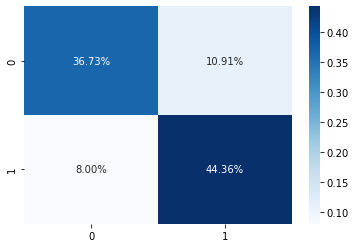

In [17]:
get_confusion_matrix(clf_lr.best_estimator_,x_test,y_test)

AUC score:  0.8931231446140797


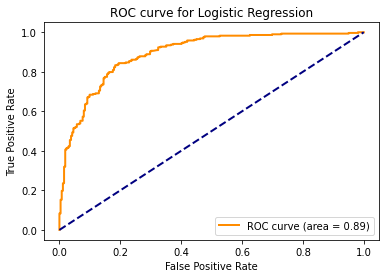

In [18]:
plot_roc(clf_lr.best_estimator_,x_test,y_test)

### Naiver Bayes

In [19]:
nb = MultinomialNB()
params = {
    "alpha":[0.25, 0.5, 1, 1.25, 1.5, 2, 4, 8],
    "fit_prior":[True, False]
}
clf_nb = GridSearchCV(nb, params, cv = kfold, scoring=scoring, refit='Accuracy')
clf_nb.fit(x_train, y_train)
print("Best score: ",clf_nb.best_score_)

Best score:  0.7875264029819838


In [20]:
fill_metrics(clf_nb)

              precision    recall  f1-score   support

    Positive       0.83      0.79      0.81       262
    Negative       0.82      0.85      0.83       288

    accuracy                           0.82       550
   macro avg       0.82      0.82      0.82       550
weighted avg       0.82      0.82      0.82       550

Confusion matrix:


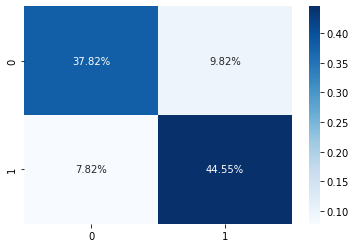

In [21]:
get_confusion_matrix(clf_nb.best_estimator_,x_test,y_test)

AUC score:  0.8618867924528302


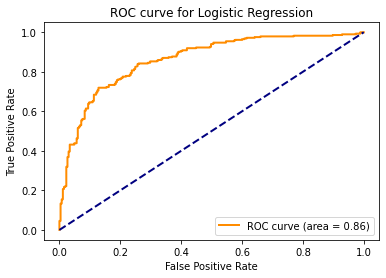

In [22]:
plot_roc(clf_nb.best_estimator_,x_test,y_test)

### SVM

In [22]:
svm = SVC(probability=True)
params = {'kernel': ['rbf'], 
          'gamma': [ 0.001, 0.01, 0.1, 1],
          'C': [1, 10, 50, 100, 200, 300]}
clf_svm = GridSearchCV(svm, params, cv = kfold, scoring=scoring, refit='Accuracy')
clf_svm.fit(x_train, y_train)
print("Best score: ",clf_svm.best_score_)

Best score:  0.7989066059225511


In [23]:
fill_metrics(clf_svm)

              precision    recall  f1-score   support

    Positive       0.81      0.78      0.80       262
    Negative       0.81      0.84      0.82       288

    accuracy                           0.81       550
   macro avg       0.81      0.81      0.81       550
weighted avg       0.81      0.81      0.81       550

Confusion matrix:


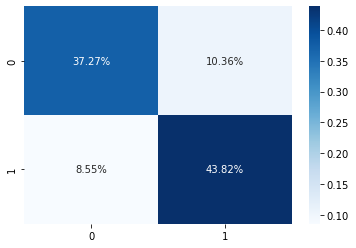

In [24]:
get_confusion_matrix(clf_svm.best_estimator_,x_test,y_test)

AUC score:  0.8800161683630194


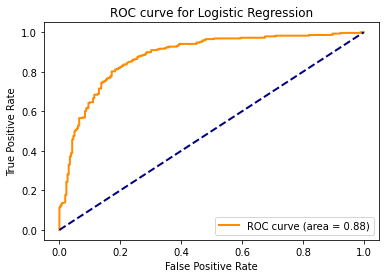

In [25]:
plot_roc(clf_svm.best_estimator_,x_test,y_test)

# LSTM MODEL

In [30]:


# Read the dataset
amazon_df = pd.read_csv("C:/Users/HP/Downloads/sentiment labelled sentences/sentiment labelled sentences/amazon_cells_labelled.txt", delimiter='\t', header=None)
imdb_df = pd.read_csv("C:/Users/HP/Downloads/sentiment labelled sentences/sentiment labelled sentences/imdb_labelled.txt", delimiter='\t', header=None)
yelp_df = pd.read_csv("C:/Users/HP/Downloads/sentiment labelled sentences/sentiment labelled sentences/yelp_labelled.txt", delimiter='\t', header=None)

# Concatenate the datasets
data = pd.concat([amazon_df, imdb_df, yelp_df], axis=0, ignore_index=True)

reviews = data[0].values
labels = data[1].values

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.2, random_state=42)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

# Convert text to sequences
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Pad sequences
max_len = 100  # Maximum sequence length
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len, padding='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len, padding='post')

# Define the LSTM model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 128, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(x_train_pad, y_train, epochs=50, batch_size=32, validation_data=(x_test_pad, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(x_test_pad, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Generate predictions
y_pred_prob = model.predict(x_test_pad)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)






Epoch 1/50
69/69 [==============================] - 17s 121ms/step - loss: 0.6954 - accuracy: 0.4982 - val_loss: 0.6984 - val_accuracy: 0.4709
Epoch 2/50
69/69 [==============================] - 3s 49ms/step - loss: 0.6931 - accuracy: 0.4955 - val_loss: 0.6937 - val_accuracy: 0.4691
Epoch 3/50
69/69 [==============================] - 3s 45ms/step - loss: 0.6933 - accuracy: 0.4982 - val_loss: 0.6960 - val_accuracy: 0.4709
Epoch 4/50
69/69 [==============================] - 3s 45ms/step - loss: 0.6930 - accuracy: 0.5141 - val_loss: 0.6955 - val_accuracy: 0.4691
Epoch 5/50
69/69 [==============================] - 3s 46ms/step - loss: 0.6930 - accuracy: 0.5141 - val_loss: 0.6961 - val_accuracy: 0.4691
Epoch 6/50
69/69 [==============================] - 3s 48ms/step - loss: 0.6929 - accuracy: 0.5141 - val_loss: 0.6945 - val_accuracy: 0.4691
Epoch 7/50
69/69 [==============================] - 3s 50ms/step - loss: 0.6928 - accuracy: 0.5141 - val_loss: 0.6939 - val_accuracy: 0.4691
Epoch 8/50


# confusion matrix

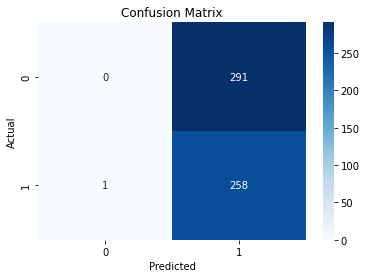

In [31]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Roc curve

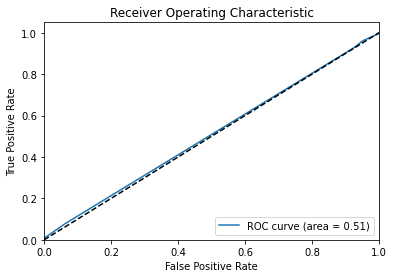

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# CNN

Epoch 1/50
69/69 [==============================] - 2s 19ms/step - loss: 0.6571 - accuracy: 0.6401 - val_loss: 0.5798 - val_accuracy: 0.7636
Epoch 2/50
69/69 [==============================] - 1s 18ms/step - loss: 0.3970 - accuracy: 0.8735 - val_loss: 0.3933 - val_accuracy: 0.8400
Epoch 3/50
69/69 [==============================] - 1s 19ms/step - loss: 0.1682 - accuracy: 0.9527 - val_loss: 0.3728 - val_accuracy: 0.8509
Epoch 4/50
69/69 [==============================] - 1s 18ms/step - loss: 0.0696 - accuracy: 0.9850 - val_loss: 0.4457 - val_accuracy: 0.8327
Epoch 5/50
69/69 [==============================] - 1s 18ms/step - loss: 0.0337 - accuracy: 0.9964 - val_loss: 0.4671 - val_accuracy: 0.8400
Epoch 6/50
69/69 [==============================] - 1s 19ms/step - loss: 0.0181 - accuracy: 0.9982 - val_loss: 0.5028 - val_accuracy: 0.8364
Epoch 7/50
69/69 [==============================] - 1s 18ms/step - loss: 0.0111 - accuracy: 0.9982 - val_loss: 0.5233 - val_accuracy: 0.8400
Epoch 8/50
69

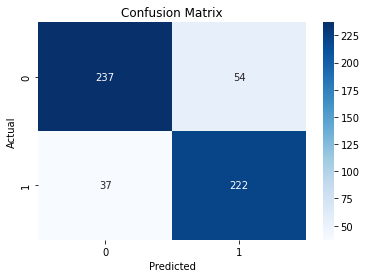

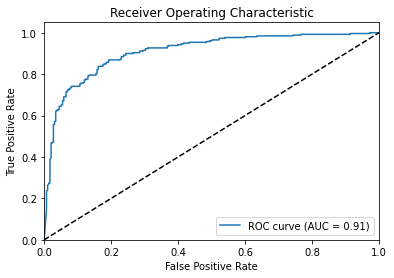

In [40]:
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 128, input_length=max_len))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(x_train_pad, y_train, epochs=50, batch_size=32, validation_data=(x_test_pad, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(x_test_pad, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Generate predictions
predictions = model.predict(x_test_pad)
binary_predictions = (predictions > 0.5).astype(int)
prediction_accuracy = (binary_predictions == y_test.reshape(-1, 1)).mean()
print("Prediction Accuracy:", prediction_accuracy)
loss, accuracy = model.evaluate(x_test_pad, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
# Generate predictions
predictions = model.predict(x_test_pad)
binary_predictions = (predictions > 0.5).astype(int)





# confusion matrix

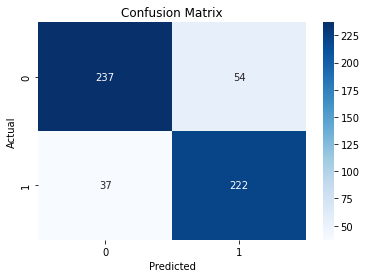

In [41]:
# Compute confusion matrix
cm = confusion_matrix(y_test, binary_predictions)

# Plot confusion matrix
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# roc curve

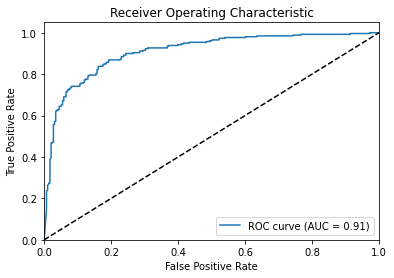

In [42]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)
auc_score = roc_auc_score(y_test, predictions)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

### Contingency table

In [44]:
import pandas as pd

results = pd.DataFrame()
results['Classifier'] = ['LR', 'NB', 'SVM']
results['Accuracy'] = acc
results.loc[3] = ['CNN', accuracy]

# Add results for LSTM
results.loc[4] = ['LSTM',accuracy]

In [45]:
results

,Classifier,Accuracy
0,LR,0.794819
1,NB,0.783437
2,SVM,0.787993
3,CNN,0.834545
4,LSTM,0.834545


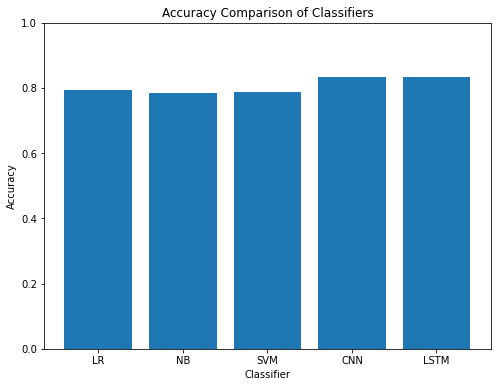

In [46]:
import matplotlib.pyplot as plt

classifiers = results['Classifier']
accuracy_scores = results['Accuracy']

plt.figure(figsize=(8, 6))
plt.bar(classifiers, accuracy_scores)
plt.title('Accuracy Comparison of Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.show()
